In [1]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

entrenamiento = pd.read_csv('train.csv')
testeo = pd.read_csv('test.csv')
muestra = pd.read_csv('sample_submission.csv')

In [2]:
import re
import string
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt to /home/franlinux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/franlinux/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Split entre entrenamiento y validación

In [3]:
entrenamiento['text'] = entrenamiento['text'].apply(preprocess_text)

X = entrenamiento.drop(['target'], axis=1)
y = entrenamiento['target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train

,id,keyword,location,text
4996,7128,military,Texas,"[courageous, and, honest, analysis, of, need, ..."
3263,4688,engulfed,NaN,"[zachzaidman, 670thescore, wld, b, a, shame, i..."
4907,6984,massacre,Cottonwood Arizona,"[tell, barackobama, to, rescind, medals, of, h..."
2855,4103,drought,"Spokane, WA","[worried, about, how, the, ca, drought, might,..."
4716,6706,lava,"Medan,Indonesia","[youngheroesid, lava, blast, amp, power, red, ..."
...,...,...,...,...
5226,7470,obliteration,Merica!,"[eganator2000, there, arent, many, obliteratio..."
5390,7691,panic,NaN,"[just, had, a, panic, attack, bc, i, dont, hav..."
860,1242,blood,NaN,"[omron, hem712c, automatic, blood, pressure, m..."
7603,10862,NaN,NaN,"[officials, say, a, quarantine, is, in, place,..."


In [5]:
X_validation

,id,keyword,location,text
2644,3796,destruction,NaN,"[so, you, have, a, new, weapon, that, can, cau..."
2227,3185,deluge,NaN,"[the, famping, things, i, do, for, gishwhes, j..."
5448,7769,police,UK,"[dt, georgegalloway, rt, galloway4mayor, ûïth..."
132,191,aftershock,NaN,"[aftershock, back, to, school, kick, off, was,..."
6845,9810,trauma,"Montgomery County, MD","[in, response, to, trauma, children, of, addic..."
...,...,...,...,...
1835,2640,crashed,Somewhere,"[smusx16475, skype, just, crashed, u, host]"
506,731,attacked,Arundel,"[christian, attacked, by, muslims, at, the, te..."
3592,5131,fatal,"New South Wales, Australia","[man, charged, over, fatal, crash, near, dubbo..."
6740,9657,thunderstorm,NaN,"[usnwsgov, severe, weather, statement, issued,..."


In [6]:
y_train

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64

In [7]:
y_validation

2644    1
2227    0
5448    1
132     0
6845    0
       ..
1835    0
506     1
3592    1
6740    1
1634    0
Name: target, Length: 1523, dtype: int64

In [8]:
log_rec = LogisticRegression(max_iter=3000, random_state=42)

params = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

## Búsqueda de hiperparámetros

In [9]:
rs = RandomizedSearchCV(
    log_rec,
    params,
    n_iter=3000,
    random_state=42,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

## Creación de features numéricas

In [10]:
X_train['word_count'] = X_train['text'].apply(len)
X_validation['word_count'] = X_validation['text'].apply(len)

X_train['avg_word_length'] = X_train['text'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
X_validation['avg_word_length'] = X_validation['text'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)

X_train['unique_word_count'] = X_train['text'].apply(lambda x: len(set(x)))
X_validation['unique_word_count'] = X_validation['text'].apply(lambda x: len(set(x)))

X_train['lexical_diversity'] = X_train['unique_word_count'] / X_train['word_count']
X_validation['lexical_diversity'] = X_validation['unique_word_count'] / X_validation['word_count']

display(X_train[['word_count', 'avg_word_length', 'unique_word_count', 'lexical_diversity']].head())

,word_count,avg_word_length,unique_word_count,lexical_diversity
4996,17,5.705882,17,1.000000
3263,15,5.333333,15,1.000000
4907,21,4.380952,19,0.904762
2855,16,4.812500,16,1.000000
4716,9,7.555556,9,1.000000


## Creación de features categóricas

In [11]:
def categorize_length(word_count):
    if word_count <= 5:
        return 'muy_corto'
    elif word_count <= 10:
        return 'corto'
    elif word_count <= 15:
        return 'medio'
    else:
        return 'largo'

X_train['length_category'] = X_train['word_count'].apply(categorize_length)
X_validation['length_category'] = X_validation['word_count'].apply(categorize_length)

urgency_words = {'fire', 'emergency', 'disaster', 'evacuate', 'help', 'urgent', 'alert',
                 'warning', 'danger', 'crisis', 'rescue', 'trapped', 'injured', 'death',
                 'killed', 'destroyed', 'damage', 'severe', 'threat', 'risk'}

def has_urgency_words(tokens):
    return 'si' if any(word in urgency_words for word in tokens) else 'no'

X_train['has_urgency'] = X_train['text'].apply(has_urgency_words)
X_validation['has_urgency'] = X_validation['text'].apply(has_urgency_words)

def categorize_diversity(diversity):
    if diversity < 0.5:
        return 'baja'
    elif diversity < 0.75:
        return 'media'
    else:
        return 'alta'

X_train['diversity_category'] = X_train['lexical_diversity'].apply(categorize_diversity)
X_validation['diversity_category'] = X_validation['lexical_diversity'].apply(categorize_diversity)

print("Features categóricas creadas:")
print("\n1. length_category:")
print(X_train['length_category'].value_counts())
print("\n2. has_urgency:")
print(X_train['has_urgency'].value_counts())
print("\n3. diversity_category:")
print(X_train['diversity_category'].value_counts())

display(X_train[['text', 'length_category', 'has_urgency', 'diversity_category']].head(10))

Features categóricas creadas:

1. length_category:
length_category
largo        2454
medio        1782
corto        1438
muy_corto     416
Name: count, dtype: int64

2. has_urgency:
has_urgency
no    5215
si     875
Name: count, dtype: int64

3. diversity_category:
diversity_category
alta     6024
media      64
baja        2
Name: count, dtype: int64


,text,length_category,has_urgency,diversity_category
4996,"[courageous, and, honest, analysis, of, need, ...",largo,no,alta
3263,"[zachzaidman, 670thescore, wld, b, a, shame, i...",medio,no,alta
4907,"[tell, barackobama, to, rescind, medals, of, h...",largo,no,alta
2855,"[worried, about, how, the, ca, drought, might,...",largo,no,alta
4716,"[youngheroesid, lava, blast, amp, power, red, ...",corto,no,alta
7538,"[wreckage, conclusively, confirmed, as, from, ...",largo,no,alta
3172,"[our, builder, is, having, a, dental, emergenc...",largo,si,alta
3932,"[bmx, issues, areal, flood, advisory, for, she...",medio,no,alta
5833,"[360wisenews, chinas, stock, market, crash, ar...",medio,no,alta
7173,"[robertoneill31, getting, hit, by, a, foul, ba...",largo,no,alta


In [12]:
X_train['keyword'] = X_train['keyword'].fillna('unknown')
X_validation['keyword'] = X_validation['keyword'].fillna('unknown')

X_train['location'] = X_train['location'].fillna('unknown')
X_validation['location'] = X_validation['location'].fillna('unknown')

cat_features = ['keyword', 'location', 'length_category', 'has_urgency', 'diversity_category']

print(f"Total de features categóricas: {len(cat_features)}")
print(f"   - Originales (2): keyword, location")
print(f"   - Creadas (3): length_category, has_urgency, diversity_category")

Total de features categóricas: 5
   - Originales (2): keyword, location
   - Creadas (3): length_category, has_urgency, diversity_category


## Embedding del texto

In [13]:
import numpy as np
import os

np.random.seed(42)

try:
    from gensim.models import KeyedVectors
    from gensim.downloader import load
    import gensim.downloader as api
    
    model_name = 'glove-twitter-25'
    
    model_path = os.path.join(os.path.expanduser('~'), 'gensim-data', model_name)
    
    if os.path.exists(model_path):
        print(f"Embeddings '{model_name}' ya descargados previamente")
        print(f"Ubicación: {model_path}")
    else:
        print(f"Descargando '{model_name}'...")
    
    word_vectors = load(model_name)
    embedding_dim = 25
    print(f"Embeddings cargados exitosamente: {embedding_dim} dimensiones")

except Exception as e:
    print(f"Error al cargar embeddings de gensim: {e}")
    
    word_vectors = None
    embedding_dim = 50

def text_to_embedding(tokens, word_vectors, embedding_dim):
    """Convierte una lista de tokens a un vector embedding promediando los word embeddings"""
    if word_vectors is not None:
        embeddings = []
        for word in tokens:
            try:
                embeddings.append(word_vectors[word])
            except KeyError:
                pass

        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(embedding_dim)
    else:
        np.random.seed(42)
        vocab = set([word for tokens in X_train['text'] for word in tokens])
        word_to_vec = {word: np.random.randn(embedding_dim) for word in vocab}

        embeddings = [word_to_vec.get(word, np.zeros(embedding_dim)) for word in tokens]
        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(embedding_dim)

X_train_embeddings = np.array([text_to_embedding(tokens, word_vectors, embedding_dim)
                                for tokens in X_train['text']])
X_validation_embeddings = np.array([text_to_embedding(tokens, word_vectors, embedding_dim)
                                     for tokens in X_validation['text']])

print(f"\nEmbeddings generados:")
print(f"   • Entrenamiento: {X_train_embeddings.shape}")
print(f"   • Validación: {X_validation_embeddings.shape}")

Embeddings 'glove-twitter-25' ya descargados previamente
Ubicación: /home/franlinux/gensim-data/glove-twitter-25
Embeddings cargados exitosamente: 25 dimensiones

Embeddings generados:
   • Entrenamiento: (6090, 25)
   • Validación: (1523, 25)


## Encoding de variables categóricas

In [14]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_train_cat_encoded = one_hot_enc.fit_transform(X_train[cat_features])
X_validation_cat_encoded = one_hot_enc.transform(X_validation[cat_features])
print(f"Features categóricas encoded: {X_train_cat_encoded.shape[1]} columnas")

Features categóricas encoded: 3003 columnas


## Entrenamiento del modelo

In [15]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

numeric_features = ['word_count', 'avg_word_length', 'unique_word_count', 'lexical_diversity']
X_train_numeric = X_train[numeric_features].values
X_validation_numeric = X_validation[numeric_features].values
print(f"Features numéricas: {len(numeric_features)} columnas")

X_train_embeddings_sparse = csr_matrix(X_train_embeddings)
X_validation_embeddings_sparse = csr_matrix(X_validation_embeddings)

X_train_numeric_sparse = csr_matrix(X_train_numeric)
X_validation_numeric_sparse = csr_matrix(X_validation_numeric)

X_train_final = hstack([X_train_embeddings_sparse, X_train_cat_encoded, X_train_numeric_sparse])
X_validation_final = hstack([X_validation_embeddings_sparse, X_validation_cat_encoded, X_validation_numeric_sparse])

print(f"\nShape final del dataset de entrenamiento: {X_train_final.shape}")
print(f"   - Embeddings: {embedding_dim} dimensiones")
print(f"   - Categóricas encoded: {X_train_cat_encoded.shape[1]} columnas")
print(f"   - Numéricas: {len(numeric_features)} columnas")
print(f"   - TOTAL: {X_train_final.shape[1]} features")
print(f"\nShape final del dataset de validación: {X_validation_final.shape}")

print("\nEntrenando modelo con RandomizedSearchCV...")
rs.fit(X_train_final, y_train)
print("Entrenamiento completado")

Features numéricas: 4 columnas

Shape final del dataset de entrenamiento: (6090, 3032)
   - Embeddings: 25 dimensiones
   - Categóricas encoded: 3003 columnas
   - Numéricas: 4 columnas
   - TOTAL: 3032 features

Shape final del dataset de validación: (1523, 3032)

Entrenando modelo con RandomizedSearchCV...
Fitting 3 folds for each of 140 candidates, totalling 420 fits


/usr/lib/python3/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 140 is smaller than n_iter=3000. Running 140 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_m

Entrenamiento completado


## Evaluación del modelo

In [25]:
from sklearn.metrics import f1_score

print("Mejores parámetros:", rs.best_params_)

y_pred_validation = rs.predict(X_validation_final)
y_pred_train = rs.predict(X_train_final)

print(f"F1 Score en validación: {f1_score(y_validation, y_pred_validation):.4f}")
print(f"F1 Score en train: {f1_score(y_train, y_pred_train):.4f}")

Mejores parámetros: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0, 'C': 1}
F1 Score en validación: 0.7695
F1 Score en train: 0.8170


## Predicciones en el conjunto de test

In [ ]:
testeo['text'] = testeo['text'].apply(preprocess_text)

testeo['word_count'] = testeo['text'].apply(len)
testeo['avg_word_length'] = testeo['text'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
testeo['unique_word_count'] = testeo['text'].apply(lambda x: len(set(x)))
testeo['lexical_diversity'] = testeo['unique_word_count'] / testeo['word_count']

testeo['length_category'] = testeo['word_count'].apply(categorize_length)
testeo['has_urgency'] = testeo['text'].apply(has_urgency_words)
testeo['diversity_category'] = testeo['lexical_diversity'].apply(categorize_diversity)

testeo['keyword'] = testeo['keyword'].fillna('unknown')
testeo['location'] = testeo['location'].fillna('unknown')

X_test_embeddings = np.array([text_to_embedding(tokens, word_vectors, embedding_dim)
                               for tokens in testeo['text']])
X_test_embeddings_sparse = csr_matrix(X_test_embeddings)

X_test_cat_encoded = one_hot_enc.transform(testeo[cat_features])

X_test_numeric = testeo[numeric_features].values
X_test_numeric_sparse = csr_matrix(X_test_numeric)

X_test_final = hstack([X_test_embeddings_sparse, X_test_cat_encoded, X_test_numeric_sparse])

print(f"Shape del dataset de test: {X_test_final.shape}")

predicciones = rs.predict(X_test_final)

submission = pd.DataFrame({
    'id': testeo['id'],
    'target': predicciones
})

submission.to_csv('submission_regresion_logistica.csv', index=False)
print("\nArchivo 'submission_regresion_logistica.csv' creado exitosamente")
print(f"Total de predicciones: {len(predicciones)}")
print(f"   • Predicciones de desastre (1): {(predicciones == 1).sum()}")
print(f"   • Predicciones de no desastre (0): {(predicciones == 0).sum()}")
print(f"   • Proporción de desastres: {(predicciones == 1).sum() / len(predicciones) * 100:.1f}%")
display(submission.head(10))

Shape del dataset de test: (3263, 3032)

Archivo 'submission_regresion_logistica.csv' creado exitosamente
Total de predicciones: 3263
   • Predicciones de desastre (1): 1260
   • Predicciones de no desastre (0): 2003
   • Proporción de desastres: 38.6%


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


## Importancia de features

In [16]:
best_model = rs.best_estimator_

coefficients = best_model.coef_[0]

feature_names = []

feature_names.extend([f'embedding_{i}' for i in range(embedding_dim)])

cat_feature_names = one_hot_enc.get_feature_names_out(cat_features)
cat_feature_names = [name.replace('%20', '_') for name in cat_feature_names]
feature_names.extend(cat_feature_names)

feature_names.extend(numeric_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("=" * 80)
print("Top 20 features más importantes")
print("=" * 80)
print("\nFeature                                          Coeficiente    |Coef|")
print("-" * 80)
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature'][:45]:<45} {row['coefficient']:>10.4f}  {row['abs_coefficient']:>8.4f}")

Top 20 features más importantes

Feature                                          Coeficiente    |Coef|
--------------------------------------------------------------------------------
keyword_oil_spill                                 1.9737    1.9737
keyword_blight                                   -1.8575    1.8575
embedding_23                                     -1.8117    1.8117
keyword_demolish                                 -1.7563    1.7563
keyword_wreckage                                  1.7327    1.7327
keyword_derailment                                1.6312    1.6312
keyword_mass_murder                               1.6141    1.6141
embedding_13                                      1.6076    1.6076
keyword_screaming                                -1.5786    1.5786
embedding_4                                      -1.5694    1.5694
embedding_9                                       1.5454    1.5454
keyword_wild_fires                                1.5440    1.5440
keyword_des

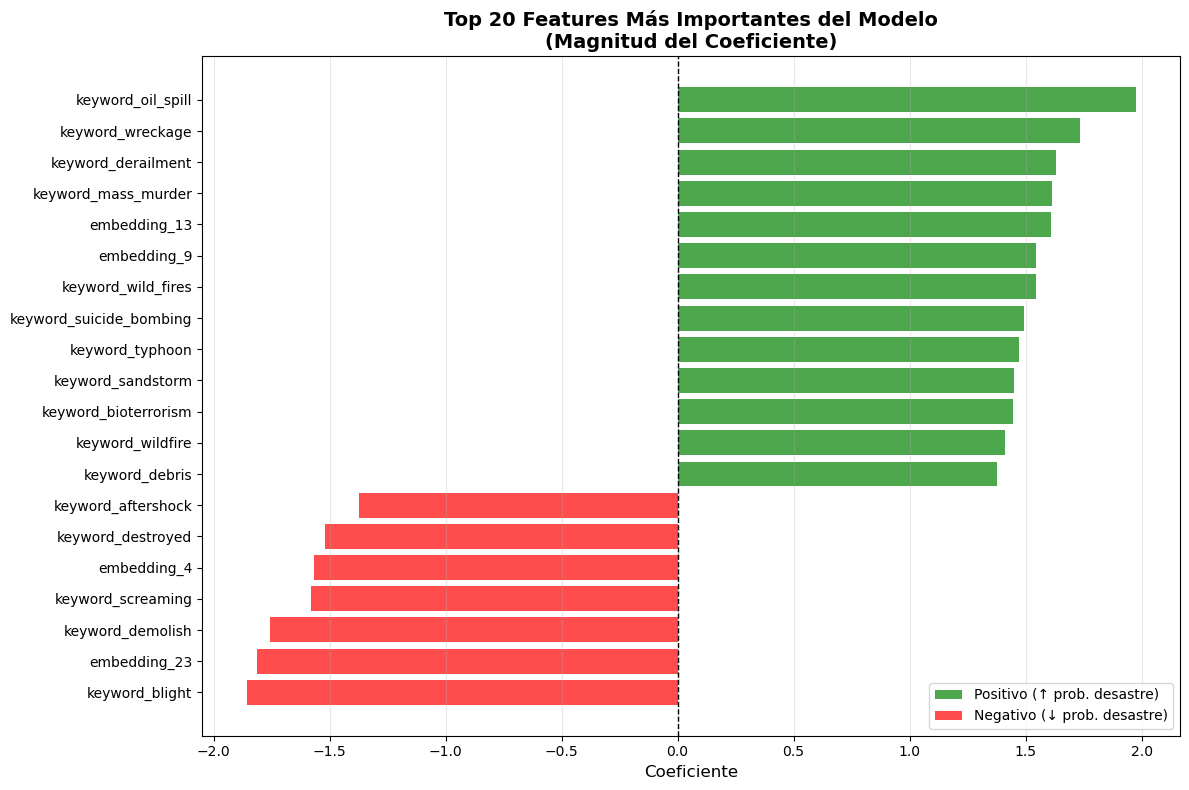


Estadísticas de los coeficientes:
   • Total de features: 3032
   • Coeficientes positivos: 1263
   • Coeficientes negativos: 1769
   • Coeficiente máximo: 1.9737
   • Coeficiente mínimo: -1.8575
   • Rango de coeficientes: 3.8312


In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20).sort_values('coefficient')
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]

plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coeficiente', fontsize=12)
plt.title('Top 20 Features Más Importantes del Modelo\n(Magnitud del Coeficiente)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Positivo (↑ prob. desastre)'),
    Patch(facecolor='red', alpha=0.7, label='Negativo (↓ prob. desastre)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

feature_types = []
for name in feature_importance['feature']:
    if name.startswith('embedding_'):
        feature_types.append('Embeddings')
    elif name in numeric_features:
        feature_types.append('Numéricas')
    else:
        feature_types.append('Categóricas')

feature_importance['type'] = feature_types

print(f"\nEstadísticas de los coeficientes:")
print(f"   • Total de features: {len(coefficients)}")
print(f"   • Coeficientes positivos: {(coefficients > 0).sum()}")
print(f"   • Coeficientes negativos: {(coefficients < 0).sum()}")
print(f"   • Coeficiente máximo: {coefficients.max():.4f}")
print(f"   • Coeficiente mínimo: {coefficients.min():.4f}")
print(f"   • Rango de coeficientes: {coefficients.max() - coefficients.min():.4f}")